# Road to the top part - 1

This notebook takes you through the procedures and techniques I used to tackle the `spot the mask challenge` competition on zindi platform. Just like [kaggle](https://www.kaggle.com/), [Zindi](https://zindi.africa/) is an African based platform that organisez data science competitions. In this challenge, I wrote three notebooks, the first and second one put me among the top 50 on the leaderboard whereas the third one put me among the top 8 on the leaderboard. Consider looking at [part 2]() and [part 3]() when you are done with this.

The challenge required one to train a model that would classify whether a picture contains people wearing masks or not. This was a knowledge competition and it didnt have prizes involved.

The first thing I did was to install all the libraries needed for the project. Fastai wildcard includes all scientific programming libraries (pandas, numpy, pytorch, etc) so using it was fine for me to get started. However you can install one at a time incase you like.

Consider installing the latest version of fastai and timm if you dont have them installed on your machine.
You can use:
    `!pip install -U fastai timm`

In [1]:
from fastai.vision.all import *
import timm

In [2]:
Path.BASE_PATH = path = Path('mask')

I used paperspace gradient for running this notebook which by default is current working directory when you 

In [3]:
cd /notebooks/

/notebooks


I used fastai's ls() method so that I could have a sense of what data I am working with. Training images were provided together with the test images in the same folder. The labels for the training dataset were provided as a csv file. 

In [4]:
path.ls()

(#7) [Path('Untitled.ipynb'),Path('Untitled1.ipynb'),Path('SampleSubmission.csv'),Path('images'),Path('test2.ipynb'),Path('.ipynb_checkpoints'),Path('train_labels.csv')]

In [5]:
df = pd.read_csv(path/"train_labels.csv")

In [6]:
df

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


Since images were in a folder, I used `get_image_files` function which gets all images from a folder. 

In [7]:
files = get_image_files(path/'images')
files

(#1817) [Path('images/vmjoagqsocvlzejinvgytizdxpbhzf.jpg'),Path('images/ljkyoarjjsfzpguocnnmteqqidnztx.jpg'),Path('images/tsdnumyxjxdtpmjzgsbuhaoibrbgur.jpg'),Path('images/radafdaijhzgynzcvgpdiaqpddfwrp.jpg'),Path('images/nrlywwygzrswfdbhjvdtakksrsvjgk.jpg'),Path('images/nncgaofbnlhkcvnvhajmgrxpomzzba.jpg'),Path('images/euaxozalqcqmhzyvxpiihzcvfzpcub.jpg'),Path('images/gzmchbgmbiwuyckveuenjgkutgaoqk.jpg'),Path('images/zbmmixvefcnotutstwrxzcxyjnqyul.jpg'),Path('images/wrgixgvogbvrvrvslnkuweluxuqlwq.jpg')...]

It's always a good habit to always try out a few examples on your code to check if it's working appropriately. Forexample here I just picked the first image, previewed it and comfirmed that the images have been retrieved correctly from the folder.

Other than that, I decided to have a glimpse on the size of the first 10 images, All images showed to be with different sizes.

In [8]:
im = PILImage.create(files[0])
im.size

(1000, 667)

In [9]:
[PILImage.create(o).size for o in files[:10]]

[(1000, 667),
 (1280, 960),
 (275, 183),
 (626, 417),
 (626, 417),
 (512, 512),
 (309, 163),
 (300, 168),
 (637, 335),
 (1024, 574)]

Since the train set was mixed up with the test set, there was need to get a way of separating our data. Lucky enough the labels of the train set were provides as a csv file. So I decided to first pick the names of the pictures in the train set from that csv file.

In [10]:
train_list = df.image.to_list()
train_list[:4]

['tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg',
 'rxgismgsvmaayzjarbfjaljhqmpbrt.jpg',
 'uuzshfrhkgrkolhwdvliqauzulurnz.jpg',
 'mjspxsagzusaznvnyxgamtrlqkqklp.jpg']

The idea I considered was to iterate through the image files (train and test) and compare them with the train_list above. By convention `FuncSplitter` makes a split based on the returned boolean value; true (if the string deosnot match) or false (If the string match). By default the indices of strings returned with false will be put in the train set, otherwise in the test set.

In [11]:
splitter = FuncSplitter(lambda o: Path(o).name not in train_list)
new_files = splitter(files)
train, test = new_files

In [12]:
train_path, test_path = files[train], files[test]

Fastai has a way of getting image dataloaders from a csv file. I considered this to be the most convinient way to load the data. After I tried having a look at a few of the images and everything seemed to be great.

In [13]:
dls = ImageDataLoaders.from_csv(path, 'train_labels.csv', seed = 42, folder='images', item_tfms = Resize(224))

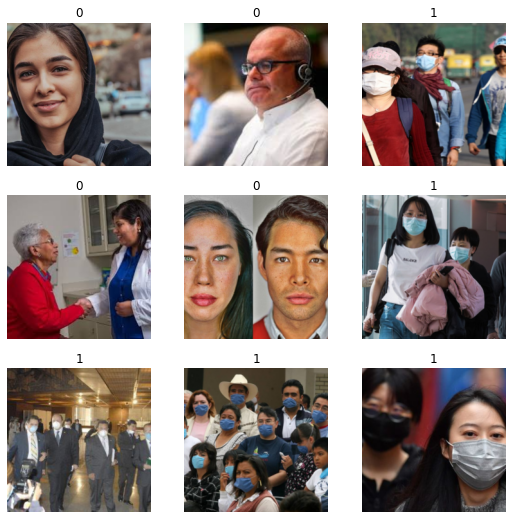

In [14]:
dls.show_batch()

## Training the model

I then passed the dataloaders, model, and metrics to the learner. I also used half mixed precision to make my training a little bit faster.

In [15]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0010000000474974513, slide=0.0063095735386013985)

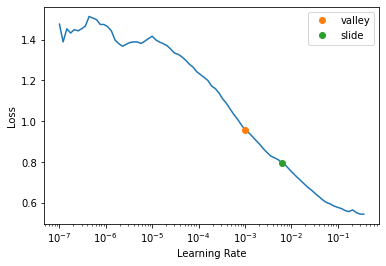

In [16]:
learn.lr_find(suggest_funcs=(valley, slide))

In [17]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.525581,0.414630,0.072797,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.201906,0.321369,0.076628,00:17
1,0.192687,0.203649,0.061303,00:17
2,0.142089,0.177576,0.042146,00:18


In [18]:
learn.export('model.pkl')

In [70]:
ss = pd.read_csv(path/'SampleSubmission.csv')
ss

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


## Preparing the test dataloaders

In [21]:
tst_files = test_path.sorted()
tst_dl = dls.test_dl(tst_files)

`get_preds` returns probabilities, labels and indices, Since the test data has no labels we omitted that by using a dash. The metric for the competition was area under a curve which implied that we just needed probabilties not direct target labels.

In [40]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

Probs returns a tensor with two columns and rows corresponding to the number of image in the test set, The first column represents the probablity that people in the image aren't wearing masks and vicevasa.

In [67]:
probs

TensorBase([[9.6471e-01, 3.5294e-02],
            [1.0000e+00, 3.1675e-09],
            [5.3687e-07, 1.0000e+00],
            ...,
            [9.9974e-01, 2.5714e-04],
            [7.3218e-04, 9.9927e-01],
            [9.6080e-01, 3.9195e-02]])

So the way we make a prediction is to choose the class with the maximum probability and assign the image to that particular class.

In [56]:
x = torch.max(probs, 1)

In [59]:
x[0][:4]

TensorBase([0.9647, 1.0000, 1.0000, 0.9541])

In [50]:
y = torch.argmax(probs, dim=1)

In [51]:
y

TensorBase([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
            0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
            1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
            1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
            0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
            0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
            0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
            1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
            1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
            0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
            0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
            1, 0, 1, 1, 1, 0

In [72]:
res = torch.where(y==0, 1-x[0], x[0])

I then converted my results to a pandas series

In [73]:
results = pd.Series(res.numpy(), name="target").round(2)
results

0      0.04
1      0.00
2      1.00
3      0.95
4      0.00
       ... 
504    0.00
505    0.00
506    0.00
507    1.00
508    0.04
Name: target, Length: 509, dtype: float32

## Making a submission

And finally, Let's us submit and get a score on the leaderboard.

In [74]:
ss['target'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image,target
aadawlxbmapqrblgxyzarhjasgiobu.png,0.04
abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.0
aclkjfvackiieiznzfcwienplielrj.jpg,1.0
aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.95
aelzzshpfxerelefnkatpczktuxjln.jpg,0.0
ajnjnkvstqesvfohaptobyasrkmcnq.jpg,0.0
akkydnvilgvzigllmboonbqbbioocs.jpg,1.0
akvjfjhgayyjwrqrczjbeyoqhhajis.jpg,0.01
alcveyvosnywyjbmngolmnblftdoje.jpg,0.0
